# Notebook Setup

## Usual libraries

In [1]:
from math import *
from datetime import datetime
from functools import partial

import pandas as pd
import numpy as np
import scipy as sp

## Graph

In [2]:
import matplotlib.pyplot as plt
import seaborn as sb

from matplotlib.ticker import FuncFormatter

## DataFrame Display Helpers

In [3]:
def display(dataframe, maxrows=999, fmt=None):
    from IPython.display import display
    
    previousMaxRow = pd.options.display.max_rows
    previousFloatFormat = pd.options.display.float_format    
    
    pd.options.display.max_rows = maxrows
    if fmt: 
        pd.options.display.float_format = fmt
        
    display(dataframe)
    
    pd.options.display.max_rows = previousMaxRow
    pd.options.display.float_format = previousFloatFormat
    

def colorNegativeRed(val):
    if val < 0 :
        return 'color: red'
    else:
        return 'color: black'
    
def formatCash(v, *args, decimals=True, zeroBar=True):
    if np.isnan(v):
        return "nan"
    elif zeroBar and v == 0:
        return "-"
    else:
        if decimals:
            fmt = "{}${:,.2f}"
        else:
            fmt = "{}${:,.0f}"                
        
        return fmt.format(v<0 and "-" or "", abs(v))
    
formatInt = "{:,.0f}".format
formatPct = "{:.1%}".format

CASH_FORMATTER = FuncFormatter(partial(formatCash, decimals=False, zeroBar=False))
PCT_FORMATTER_DEC_1 = FuncFormatter(formatPct)
PCT_FORMATTER_DEC_NONE = FuncFormatter("{:.0%}".format)

# Pynetrees Stuff

In [4]:
from pynetrees import *
import pynetrees.cashflow
from pynetrees.valueactualizer import *

# Cashflows

## Indexed Series

In [5]:
CF = pynetrees.cashflow.create # helper
AN = pynetrees.cashflow.indexAnnuity

cf0 = CF(-100) # a scalar is taken at index 0
cf1 = CF({1:10, 3:10, 10:100}) # an explicit index is used
cf2 = AN(7, 12, 5) # annuity

print("cf0:")
display(cf0)
print("cf1:")
display(cf1)
print("cf2:")
display(cf2)

cf0:


0   -100
dtype: int64

cf1:


1      10
3      10
10    100
dtype: int64

cf2:


7     5
8     5
9     5
10    5
11    5
12    5
13    5
14    5
15    5
16    5
17    5
18    5
dtype: int64

### Internal composition with indexed series

In [6]:
cfTotal = pynetrees.cashflow.combineCashflows((cf0,cf1,cf2))
display(cfTotal)

0    -100.0
1      10.0
3      10.0
7       5.0
8       5.0
9       5.0
10    105.0
11      5.0
12      5.0
13      5.0
14      5.0
15      5.0
16      5.0
17      5.0
18      5.0
dtype: float64

### Internal TVM with indexed series

In [7]:
npv = IndexedNPV(0.1)
print("NPV, 10%:", npv.actualize(cfTotal))

npv.ratePerPeriod = 0
print("NPV, 0% (aka, sum):", npv.actualize(cfTotal))

print("Time to recovery:", TTR_ACTUALIZER.actualize(cfTotal))

NPV, 10%: -25.610856949893815
NPV, 0% (aka, sum): 80.0
Time to recovery: 10


## Period Series

In [8]:
CF = pynetrees.cashflow.createMonths # helper
AN = pynetrees.cashflow.annuityMonths

cf0 = CF({"2017-12":-100})
cf1 = CF({"2018-01":10, "2018-03":10, "2018-10":100}) # an explicit index is used

cf2 = pd.Series(5, pd.period_range("2018-07", periods=12, freq="M")) # a pandas series can be used directly. Here, an annuity...

def annuity(base, count, ammount):
    return pd.Series(ammount, pd.period_range(base, periods=count, freq="M"))

cf2 = annuity("2018-07", 12, 5)

print("cf0:")
print(cf0)
print("cf1:")
display(cf1)
print("cf2:")
display(cf2)

cf0:
2017-12   -100
Freq: M, dtype: int64
cf1:


2018-01     10
2018-03     10
2018-10    100
Freq: M, dtype: int64

cf2:


2018-07    5
2018-08    5
2018-09    5
2018-10    5
2018-11    5
2018-12    5
2019-01    5
2019-02    5
2019-03    5
2019-04    5
2019-05    5
2019-06    5
Freq: M, dtype: int64

### Internal composition with indexed series

In [9]:
cfTotal = pynetrees.cashflow.combineCashflows((cf0,cf1,cf2))
display(cfTotal)

2017-12   -100.0
2018-01     10.0
2018-03     10.0
2018-07      5.0
2018-08      5.0
2018-09      5.0
2018-10    105.0
2018-11      5.0
2018-12      5.0
2019-01      5.0
2019-02      5.0
2019-03      5.0
2019-04      5.0
2019-05      5.0
2019-06      5.0
Freq: M, dtype: float64

### Internal TVM with indexed series

In [10]:
firstPeriod = pd.Period("2017-12", "M")
npv = PeriodNPV(0.1, firstPeriod)
print("NPV, 10%:", npv.actualize(cfTotal))

npv.ratePerPeriod = 0
print("NPV, 0% (aka, sum):", npv.actualize(cfTotal))

print("Time to recovery:", TTR_ACTUALIZER.actualize(cfTotal))

NPV, 10%: -25.610856949893815
NPV, 0% (aka, sum): 80.0
Time to recovery: 10


In [ ]:
from pynetrees.strategy import Strategy, rpExpected, selectMaxRP
from pynetrees.valueactualizer import PeriodNPV
from pynetrees.cashflow import createDays as CF
from pynetrees.jupyter import showTree

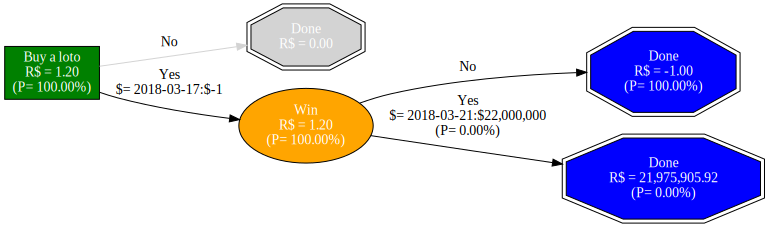

In [22]:
root = Decision("Buy a loto", [
    Transition("No"),
    Transition("Yes", CF({"2018-03-17":-1}), target=Event("Win", [
        Transition("No"),
        Transition("Yes", CF({"2018-03-21":22_000_000}), 1 / 10_000_000)]))])


solver = Solver(root, Strategy(rpExpected, selectMaxRP), PeriodNPV(0.1 / 365, pd.Period("2018-03-17", "D")))
solver.solve()

showTree(root, cashflowFormat="${:,.0f}")



In [33]:
from pynetrees.render import GraphvizEngine
eng = GraphvizEngine(root, "${:,.0f}", "${:,.0f}", "{:,.5%}")
graph = eng.render("svg")
graph.view("/tmp/down/asdf.svg")

'/tmp/down/asdf.svg.svg'

In [ ]:
CF(-100) # A scalar; no time information.
CF({1:10, 3:10, 10:100}) # An indexed series
CF({"2018-01":10, "2018-03":10, "2018-10":100}) # A period Series (by month)